# EMODnet workshop on machine learning

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

## Introduction

Let's implement some machine learning techniques to perform classification and regression.
I have prepared a dataset for you, describing some shellfish habitat locations on the Dutch coast.

We first import some packages to facilitate data manipulation and plotting.
We will be using `pandas` dataframes. For plotting, we will use `matplotlib` and `seaborn`. Throughout the text, you will encounter some more import statements. I could have included them all here, but I prefer to keep them close to where we first use them, so you can easily know what to google for inspiration or more explanation.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

I have prepared different datasets. The datasets consist of 20 000 samples, but differ in the number of classes they contain. This will make the classification easier or harder (as good as impossible).

Datsets are publicly hosted at gist.github.com.

Uncomment one `url` below to choose your dataset.
Best to start with the small 3 classes dataset first.

In [0]:
# Small many classes dataset
#url = 'https://gist.githubusercontent.com/dvorkbod/1c50ff0091b7bbd3e9e8cb8f2a2800fd/raw/16ed8f92e493c2fa5e22867b45556c8b66d544dc/DutchShellFish_restricted_manyclasses.csv'

# Tiny many classes dataset
#url = 'https://gist.githubusercontent.com/dvorkbod/1c50ff0091b7bbd3e9e8cb8f2a2800fd/raw/16ed8f92e493c2fa5e22867b45556c8b66d544dc/DutchShellFish_restricted_tinysample.csv'

# Small 7 classes dataset
#url = 'https://gist.githubusercontent.com/dvorkbod/1c50ff0091b7bbd3e9e8cb8f2a2800fd/raw/16ed8f92e493c2fa5e22867b45556c8b66d544dc/DutchShellFish_restricted_7classes.csv'

# Small 5 classes dataset
#url = 'https://gist.githubusercontent.com/dvorkbod/1c50ff0091b7bbd3e9e8cb8f2a2800fd/raw/16ed8f92e493c2fa5e22867b45556c8b66d544dc/DutchShellFish_restricted_5classes.csv'

# Small 3 classes dataset
url = 'https://gist.githubusercontent.com/dvorkbod/433cc731c5d497d1db6140225361dbdb/raw/4fb2d10a5bb782c3f643315d6d5fb487964b1367/DutchShellFish_restricted_3classes.csv'

# Tiny 3 classes dataset
#url = 'https://gist.githubusercontent.com/dvorkbod/433cc731c5d497d1db6140225361dbdb/raw/4fb2d10a5bb782c3f643315d6d5fb487964b1367/DutchShellFish_restricted_3classes_tiny.csv'

class_df = pd.read_csv(url)

NameError: ignored

## First look at the data

Now that we have picked a dataset, let's take a look at the column names. These are the *features* of the objects in the dataset, as well as the *class* of the object.

In [0]:
class_df.columns

Index(['datecollected', 'yearcollected', 'monthcollected', 'decimallongitude',
       'decimallatitude', 'Bedabundance', 'fishing', 'bathy', 'BO_phosphate',
       'BO_nitrate', 'BO_salinity', 'BO_sstmax', 'BO_sstmean', 'BO_dissox',
       'BO2_curvelmax_bdmax', 'BO2_lightbotmax_bdmax', 'coastdist',
       'substrate', 'scientificname'],
      dtype='object')

The `scientificname` is the name of the shellfish observed at the given longitude and latitude.
The remainding indicators describe the seawater conditions at that location, as well as the fishing intensity.
More to the point, we have:

* datecollected, monthcollected: YMD and month of sampling
* decimallongitude, decimallatitude: location of sampling
* Bedabundance: count of individuals per m² (#/m^2)
* fishing: fishing intensity (average number of hours spent by Fishing ships in a square kilometre over a month)
* bathy: bathymetry information
* BO_phosphate, BO_nitrate, BO_salinity: environmental layers: phosphate, nitrate, salinity
* BO_sstmax, BO_sstmean: : max and mean sea surface temperature
* BO_dissox: dissolved oxygen
* BO2_curvelmax_bdmax: Current velocity (maximum at max depth)
* BO2_lightbotmax_bdmax: Light at bottom (maximum at max depth)
* coastdist: distance to the coast in meters
* substrate: type of substrate
* scientificname: species

We can observe class distributions by plotting the number of times each `scientificname` is present in the dataset.

Let's create `label_id` to refer to `scientificname`. That way, if we later want to classify something else, we have to adjust our code in only one location.

In [0]:
label_id = 'scientificname'

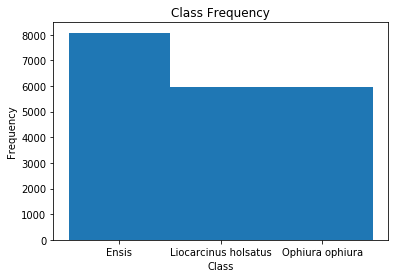

In [0]:
unique, counts = np.unique(class_df[label_id], return_counts=True)

plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In the three-class dataset, we have one class that is more prevalent, and two that are about equally common.

#### Consider plotting the substrate distribution as well. You can repurpose the code from above!

## Correlation of descriptors

A first step in machine learning is often to look at the correlation between different indicators. Some indicators that are highly correlated with each other could end up being redundant.

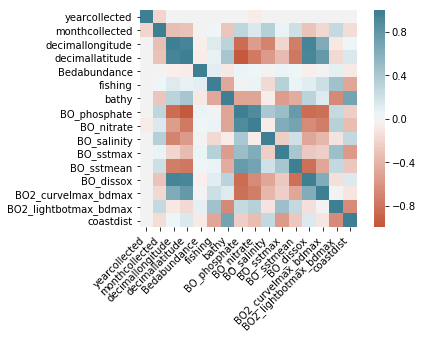

In [0]:
corr = class_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Given your knowledge of marine ecology, do the above correlations surprise you? Do they make sense?
This type of expert knowledge is sometimse also called domain knowledge. Incorporating domain knowledge in feature selection and so on used to be a very important step in achieving good results in machine learning.

These days, when doing deep learning, this is often no longer the case: The machine is fed with so much raw data that it lears the domain knowledge by itself!

Bedabundance isn't really correlated to anything else. Let's take a look at this feature.

In [0]:
class_df['Bedabundance'].describe()

count    20000.000000
mean        10.482118
std         71.786574
min          0.020000
25%          0.221000
50%          0.702000
75%          3.184500
max       4304.176000
Name: Bedabundance, dtype: float64

Those percentiles are weird! That max value seems very high compared to the 75% percentile. Let's plot all of the values.

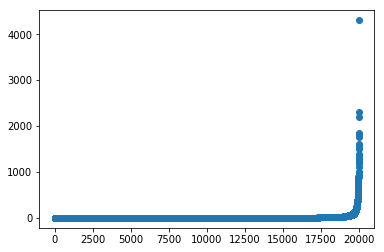

In [0]:
plt.scatter(np.arange(0,len(class_df)),class_df['Bedabundance'].sort_values())

So, it turns out there are some major differences between the Bedabundances. In case you wanted to chop off the data after the 90% percentile, comment out the next line of code. When continuing on with the rest of this notebook, try to think about what effects this could have. Not every technique will be equally strongly affected.

In [0]:
class_df = class_df[class_df['Bedabundance'] < class_df['Bedabundance'].quantile(.90)]

If you did remove the top 10% of the Bedabundance sites, consider checking what happened to the correlation matrix.

## Classification

To prepare the data for classification, we will separate the class, the `label_id`, from the features.

We will store the labels in a dataframe `y`, and the features in a dataframe `x`.

In [0]:
y = class_df[label_id]
x = class_df.drop([label_id], axis=1)

print ("dataset : ",class_df.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)

dataset :  (18000, 19)
x :  (18000, 18)
y :  (18000,)


the `head()` command on a dataframe returns the first 5 rows. We often use it to take a look at the columns of the dataset.

In [0]:
x.head()

,datecollected,yearcollected,monthcollected,decimallongitude,decimallatitude,Bedabundance,fishing,bathy,BO_phosphate,BO_nitrate,BO_salinity,BO_sstmax,BO_sstmean,BO_dissox,BO2_curvelmax_bdmax,BO2_lightbotmax_bdmax,coastdist,substrate
0,2011-04-11,2011,4,4.083333,52.000000,2.474,3.580371,9.470000,1.3149,23.789000,32.712002,20.052999,12.533,5.696,0.197045,51.959618,1163.095498,Muddy sand
1,2014-06-26,2014,6,3.733333,51.766667,0.617,2.567846,4.050000,1.3208,22.468000,33.276001,19.679001,12.216,5.707,0.194461,52.213890,2891.283835,Sand
2,2006-07-05,2006,7,4.625000,53.133333,0.256,1.027181,21.440001,0.8338,16.073000,33.201000,19.153000,11.706,5.962,0.330311,0.000172,9061.493935,Coarse substrate
3,2007-04-24,2007,4,6.166667,53.550000,2.177,7.273304,13.780000,0.9326,21.235001,31.950001,19.655001,11.557,6.291,0.272504,52.218163,5174.087562,Sand
4,2015-05-04,2015,5,3.883333,51.866667,0.353,14.173340,6.980000,1.3188,23.136999,33.012001,19.698999,12.213,5.697,0.202623,20.613363,4246.686223,Sand


The "datecollected" feature is a string. Let's drop it, and use month and year instead.

In [0]:
x.drop(['datecollected'], axis=1,inplace=True)

In [0]:
x = pd.concat([x, pd.get_dummies(x['yearcollected'], prefix='month_')], axis=1)
x = pd.concat([x, pd.get_dummies(x['monthcollected'], prefix='year_')], axis=1)
x = pd.concat([x, pd.get_dummies(x['substrate'])], axis=1)

x.drop(['yearcollected'], axis=1,inplace=True)
x.drop(['monthcollected'], axis=1,inplace=True)
x.drop(['substrate'], axis=1,inplace=True)

A more indepth examination is possible with the `describe()` command.

In [0]:
x.describe()

,decimallongitude,decimallatitude,Bedabundance,fishing,bathy,BO_phosphate,BO_nitrate,BO_salinity,BO_sstmax,BO_sstmean,BO_dissox,BO2_curvelmax_bdmax,BO2_lightbotmax_bdmax,coastdist,month__2004,month__2005,month__2006,month__2007,month__2008,month__2009,month__2010,month__2011,month__2012,month__2013,month__2014,month__2015,month__2016,month__2017,year__3,year__4,year__5,year__6,year__7,year__8,year__9,Coarse substrate,Mixed sediment,Muddy sand,Sand,Sandy mud,Seabed
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.00000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,4.532537,52.589559,1.684170,4.120040,14.889183,1.085573,20.360427,32.908975,19.461016,11.883879,5.904686,0.250199,2.048642e+01,8619.186728,0.049667,0.046111,0.070222,0.081111,0.074056,0.072500,0.071278,0.069556,0.067889,0.071333,0.081611,0.084611,0.084222,0.075833,0.008222,0.40850,0.323889,0.216778,0.030167,0.003278,0.009167,0.055278,0.001333,0.011889,0.829722,0.097167,0.004611
std,0.856364,0.746854,2.580633,5.357022,6.801131,0.216050,2.560947,0.463071,0.313240,0.267694,0.201641,0.050850,2.468351e+01,5502.211419,0.217261,0.209732,0.255528,0.273013,0.261869,0.259321,0.257295,0.254404,0.251562,0.257388,0.273779,0.278310,0.277729,0.264739,0.090305,0.49157,0.467971,0.412061,0.171050,0.057160,0.095306,0.228528,0.036491,0.108389,0.375887,0.296193,0.067750
min,3.162500,51.383333,0.020000,0.000054,-0.240000,0.739700,14.152000,31.379000,18.707001,11.377000,5.671000,0.109856,7.068152e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800000,51.850000,0.206000,0.709532,9.420000,0.874500,18.339001,32.581001,19.256001,11.644000,5.735000,0.210191,8.470287e-04,4296.762423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.458333,52.550000,0.567000,1.895385,15.940000,1.090600,20.849001,32.956001,19.462999,11.895000,5.823000,0.246820,4.290867e-01,7548.709778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.125000,53.450000,1.828000,5.317977,20.520000,1.295800,22.563000,33.236000,19.642000,12.051000,6.099000,0.287816,5.153546e+01,11853.852833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,6.541667,53.700000,13.276000,53.632763,30.340000,1.493800,24.700001,34.037998,21.150000,12.841000,6.366000,0.371960,5.532480e+01,25144.521954,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We will split the dataset in a training set and a test set.

In [0]:
#Selective import Scikit Learn 
from sklearn.model_selection import train_test_split

# Generate Training and Validation Sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3) #0.3 data as data test

#converting to float 32bit - not actually needed
#x_train = np.array(x_train).astype(np.float32)
#x_test  = np.array(x_test).astype(np.float32)
#y_train = np.array(y_train).astype(np.float32)
#y_test  = np.array(y_test).astype(np.float32)

#print data split for validation
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12600, 41) (12600,)
(5400, 41) (5400,)


### Neural Network Classification

Let's dive straight in with a neural network classifier. Spoiler: It won't work very well on factory settings. Or even when fiddling with the hidden layer sizes and learning rates. Nevertheless, there are some settings where the network starts to learn a little bit.
The starting `hidden_layer_sizes=(100,5), max_iter=2000, alpha=0.01, solver='adam'` is not one of those settings.


> Hidden layer sizes allow to specify how big the network has to be.
>
> The alpha term determines how fast it learns from the input it gets. If it becomes too large, the network reacts too fast and goes all over the place.
>
> There are three different solvers for weight optimization in the MLPClassifier:
>
>> ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
>> ‘sgd’ refers to stochastic gradient descent.
>> ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
>>
>> Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.


In [0]:
#Importing our model
from sklearn.neural_network import MLPClassifier

#model initialization
Model = MLPClassifier(hidden_layer_sizes=(400,20), max_iter=2000, alpha=0.001, #try changing hidden layers and learning rate alpha
                     solver='adam', verbose=0,  random_state=121) #try verbose=0 to train with out logging
#train our model
h=Model.fit(x_train,y_train)
#use our model to predict
NN_pred=Model.predict(x_test)

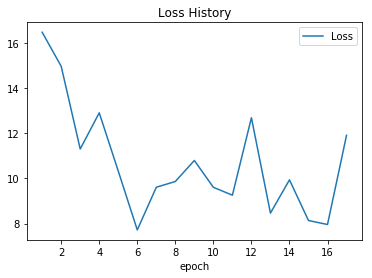

In [0]:
import matplotlib.pyplot as plt

plt.plot(h.loss_curve_)
plt.title('Loss History')
plt.xlabel('epoch')
plt.legend(['Loss'])

In [0]:
#scikit for machine learning reporting
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(classification_report(y_test,NN_pred)) # Print summary report

                      precision    recall  f1-score   support

               Ensis       0.66      0.12      0.21      1971
Liocarcinus holsatus       0.46      0.84      0.60      1803
     Ophiura ophiura       0.37      0.40      0.38      1626

            accuracy                           0.45      5400
           macro avg       0.50      0.45      0.40      5400
        weighted avg       0.51      0.45      0.39      5400



The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), sample average (only for multilabel classification) and micro average (averaging the total true positives, false negatives and false positives) 

We also take a look at the confusion matrix, showing which objects get (mis)classified as which.

In [0]:
print(confusion_matrix(y_test, NN_pred)) # Print Confusion matrix 

[[ 245  891  835]
 [  34 1521  248]
 [  90  893  643]]


In [0]:
print('accuracy is ',accuracy_score(NN_pred,y_test)) # Print accuracy score

accuracy is  0.4461111111111111


### Decision trees

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

It will do so by learning a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

Some advantages of decision trees are:

> Simple to understand and to interpret. Trees can be visualised.
> 
> Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. > Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable.
> 
> Able to handle multi-output problems.
> 
> Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
> 
> Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
> 
> Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

> Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
> 
> Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
> 
> The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
> 
> There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
> 
> Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.



**Which of these advantages and disadvantages do you think will come in to play here?**

In [0]:
from sklearn import tree

treemodel = tree.DecisionTreeClassifier()

In [0]:
treemodel.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
tree_pred = treemodel.predict(x_test)

from sklearn.metrics import accuracy_score

print(classification_report(y_test,tree_pred))

                      precision    recall  f1-score   support

               Ensis       0.50      0.50      0.50      1971
Liocarcinus holsatus       0.51      0.49      0.50      1803
     Ophiura ophiura       0.37      0.39      0.38      1626

            accuracy                           0.46      5400
           macro avg       0.46      0.46      0.46      5400
        weighted avg       0.46      0.46      0.46      5400



In [0]:
score = accuracy_score(y_test, tree_pred)
print(score)

0.46166666666666667


In [0]:
confusion_matrix(y_test, tree_pred)

array([[979, 399, 593],
       [440, 886, 477],
       [529, 469, 628]])

### Random Forest

We will now test an upgrade to decision trees, a random forest. A random forest consists of---you might have guessed it---a number of decision trees forming an *ensemble*.

In random forests, each tree in the ensemble is built from a sample drawn with replacement from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size `max_features`.

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

In [0]:
RF_model = RandomForestClassifier(**parameters)

In [0]:
RF_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
RF_pred = RF_model.predict(x_test)

In [0]:
score = accuracy_score(y_test, RF_pred)
print(score)

0.5459259259259259


In [0]:
print(classification_report(y_test,RF_pred))

                      precision    recall  f1-score   support

               Ensis       0.58      0.58      0.58      1971
Liocarcinus holsatus       0.55      0.80      0.65      1803
     Ophiura ophiura       0.46      0.22      0.30      1626

            accuracy                           0.55      5400
           macro avg       0.53      0.53      0.51      5400
        weighted avg       0.53      0.55      0.52      5400



In [0]:
confusion_matrix(y_test, RF_pred)

array([[1146,  545,  280],
       [ 218, 1441,  144],
       [ 619,  646,  361]])

#### ADA-boost classifier

Not all classes seemed as easily recognised, earlier on. Especially the third class seemed to present the classifier with difficulties. We will now test the ADA-boost classifier. 

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.


In [0]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [0]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(x_train, y_train)

#Predict the response for test dataset
ADA_pred = model.predict(x_test)

In [0]:
score = accuracy_score(y_test, ADA_pred)
score

0.5274074074074074

In [0]:
print(classification_report(y_test,ADA_pred))

                      precision    recall  f1-score   support

               Ensis       0.58      0.53      0.56      1971
Liocarcinus holsatus       0.56      0.72      0.63      1803
     Ophiura ophiura       0.39      0.31      0.35      1626

            accuracy                           0.53      5400
           macro avg       0.51      0.52      0.51      5400
        weighted avg       0.52      0.53      0.52      5400



In [0]:
confusion_matrix(y_test, ADA_pred)

array([[1050,  460,  461],
       [ 186, 1293,  324],
       [ 566,  555,  505]])

## Regression

### Linear Regression

We will now perform some regression techniques. Trying to predict bed abundance might be a bit of a stretch, but we can try. Perhaps the phyisco chemical characteristics might be easier. Remember how they these were quite correlated, after all.

We first create a new dataset and again define the target and create dummy variables for year and month.

In [0]:
reg_df = class_df# pd.read_csv(url)

print ("dataset : ",reg_df.shape)

dataset :  (18000, 19)


In [0]:
target = 'BO2_curvelmax_bdmax'
#target = 'Bedabundance'

y = reg_df[target]

x = reg_df.drop([target], axis=1)
x = pd.concat([x, pd.get_dummies(reg_df['scientificname'])], axis=1)
x = pd.concat([x, pd.get_dummies(x['yearcollected'], prefix='year_')], axis=1)
x = pd.concat([x, pd.get_dummies(x['monthcollected'], prefix='month_')], axis=1)
x = pd.concat([x, pd.get_dummies(x['substrate'])], axis=1)

x.drop(['scientificname'], axis=1,inplace=True)
x.drop(['datecollected'], axis=1,inplace=True)
x.drop(['yearcollected'], axis=1,inplace=True)
x.drop(['monthcollected'], axis=1,inplace=True)
x.drop(['substrate'], axis=1,inplace=True)
x.drop(['decimallatitude'], axis=1,inplace=True)
x.drop(['decimallongitude'], axis=1,inplace=True)

print ("dataset : ",reg_df.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)

dataset :  (18000, 19)
x :  (18000, 41)
y :  (18000,)


In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3) #0.3 data as data test
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
model.score(x_train,y_train)

0.8813535278953175

Text(0, 0.5, 'prediction')

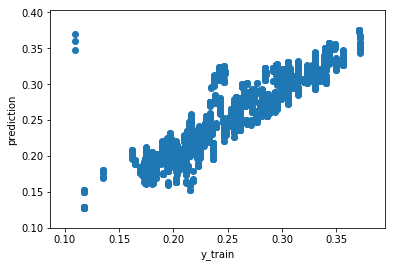

In [0]:
plt.scatter(y_train,model.predict(x_train))
plt.xlabel('y_train')
plt.ylabel('prediction')

Here we could actually see very rudimentary domain knowledge being important when trying to estimate Bedabundance. Abundances smaller than zero dont make sense, but linear regression doesn't know that. Linear regression only knows how to try and fit lines through clouds...

In [0]:
output = model.predict(x_test)

In [0]:
model.score(x_test,y_test)

0.8912470960037642

Text(0, 0.5, 'prediction')

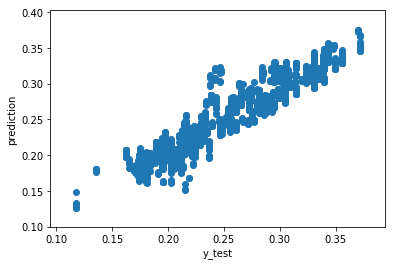

In [0]:
plt.scatter(y_test,output)
plt.xlabel('y_test')
plt.ylabel('prediction')

### Random Forest Regression

Similar to random forest classification, a random forest regressions creates an ensemble of different regressions. This can help when the relation isn't properly captured by the linear regression, when it is not 

In [0]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(**parameters)
RF_model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
RF_model.score(x_test,y_test)

0.9557544486033251

Text(0, 0.5, 'prediction')

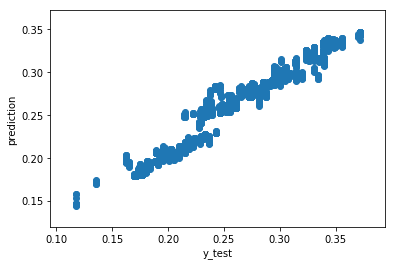

In [0]:
plt.scatter(y_test,RF_model.predict(x_test))
plt.xlabel('y_test')
plt.ylabel('prediction')

As an added bonus, Random Forest Regression allows you to get an idea about the importance of the different features that were most often used.

In [0]:
pd.DataFrame({'Variable':x.columns,
              'Importance':RF_model.feature_importances_}).sort_values('Importance', ascending=False)


,Variable,Importance
8,BO_dissox,2.715729e-01
3,BO_phosphate,2.204262e-01
4,BO_nitrate,1.422850e-01
7,BO_sstmean,1.118744e-01
5,BO_salinity,8.092014e-02
9,BO2_lightbotmax_bdmax,4.211891e-02
6,BO_sstmax,3.779603e-02
2,bathy,2.533595e-02
10,coastdist,1.720726e-02
1,fishing,1.658735e-02


### An AdaBoost regressor.

Much like the AdaBoost classifier, an AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases

In [0]:
from sklearn.ensemble import AdaBoostRegressor

In [0]:
ADAregr = AdaBoostRegressor(random_state=0, n_estimators=100)
ADAregr.fit(x_train, y_train) 

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

Much like the Random Forest Regressor, ADAboost gives you the importances of the different features. When you compare these to the ones from the Random Forest Regressor, does anything catch your eye?

In [0]:
pd.DataFrame({'Variable':x.columns,
              'Importance':ADAregr.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
8,BO_dissox,0.316386
3,BO_phosphate,0.253280
6,BO_sstmax,0.098606
4,BO_nitrate,0.090407
7,BO_sstmean,0.066976
9,BO2_lightbotmax_bdmax,0.065401
5,BO_salinity,0.044901
10,coastdist,0.030864
2,bathy,0.026377
40,Seabed,0.003645


In [0]:
ADAregr_pred = ADAregr.predict(x_test)  
ADAregr.score(x_test, y_test)

0.9134187702357311

Text(0, 0.5, 'prediction')

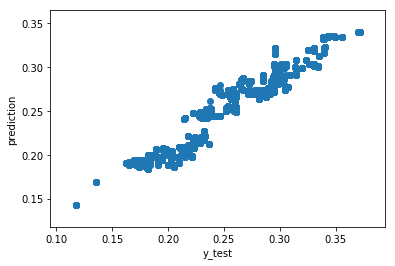

In [0]:
plt.scatter(y_test,ADAregr_pred)
plt.xlabel('y_test')
plt.ylabel('prediction')

## Appendix

## Better correlation plot helper functions

The standard correlation plot is rather hard to parse. Let's make a prettier one!

In [0]:
# Better correlation plot
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


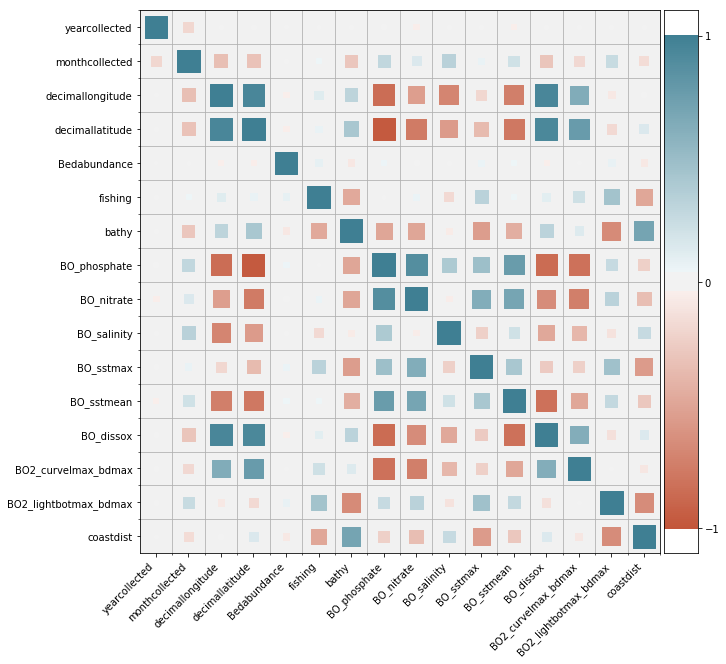

In [0]:
plt.figure(figsize=(10, 10))
corrplot(corr)

## Make a fake regression dataset

Let's make a fake data set to play around with and compare the performance of the different regressors.

Handily, `sklearn` has the tools needed to make this a breeze.

In [0]:
from sklearn.datasets import make_regression

x_constructed, y_constructed = make_regression(n_features=10, n_informative=4, random_state=0, shuffle=False, noise=1.0)

In [0]:
constructed_data = [x_constructed, y_constructed]
constructed_df = pd.DataFrame(x_constructed,columns=['ind1','ind2','ind3','ind4','ind5','ind6','ind7','ind8','ind9','ind10'])
constructed_df['target'] = y_constructed

In [0]:
constructed_df.head()

,ind1,ind2,ind3,ind4,ind5,ind6,ind7,ind8,ind9,ind10,target
0,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,0.950088,-0.151357,-0.103219,0.410599,475.627312
1,0.144044,1.454274,0.761038,0.121675,0.443863,0.333674,1.494079,-0.205158,0.313068,-0.854096,192.786074
2,-2.552990,0.653619,0.864436,-0.742165,2.269755,-1.454366,0.045759,-0.187184,1.532779,1.469359,-159.214723
3,0.154947,0.378163,-0.887786,-1.980796,-0.347912,0.156349,1.230291,1.202380,-0.387327,-0.302303,-230.429190
4,-1.048553,-1.420018,-1.706270,1.950775,-0.509652,-0.438074,-1.252795,0.777490,-1.613898,-0.212740,-147.236330


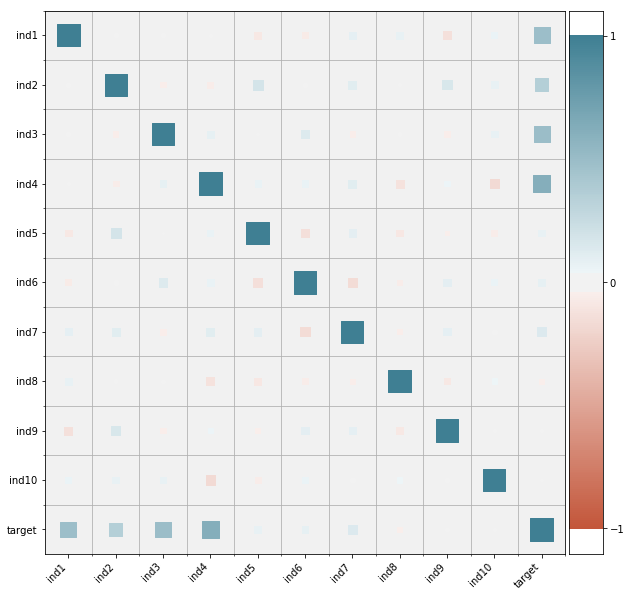

In [0]:
plt.figure(figsize=(10, 10))
corrplot(constructed_df.corr())

Let's create some test and training sets by splitting the constructed set.

In [0]:
x_c_train, x_c_test, y_c_train, y_c_test = train_test_split(x,y, test_size=0.3) #0.3 data as data test

Back to you to test the regressors we already played around with before.

# This concludes my part of the notebook. 
Go forth and extend!